In [1]:
import matplotlib.pyplot as plt
import numpy as np
import intake
from dask.diagnostics import ProgressBar

In [2]:
from cmip6_preprocessing.utils import google_cmip_col

# Initialize the Pangeo CMIP6 cloud collection
col = google_cmip_col() 


## Filtering the data using specifications 

In [3]:
# function which shows us what different models we have which has specific experiment_id and variable_id
def model_list(experiment_id1,experiment_id2,variable_id1,variable_id2):
    list1 = col.df[col.df.experiment_id == experiment_id1].source_id.unique()
    list2 = col.df[col.df.experiment_id == experiment_id2].source_id.unique()

    elist = np.intersect1d(list1,list2)

    # all source_id with variable_id == 'no3os' or 'tos'
    vlist1 = col.df[col.df.variable_id == variable_id1].source_id.unique()
    vlist2 = col.df[col.df.variable_id == variable_id2].source_id.unique()

    vlist = np.intersect1d(vlist1,vlist2)

    model = np.intersect1d(vlist,elist)
    return model

In [4]:
model_list('historical','ssp585','tos','no3os') 

array(['ACCESS-ESM1-5', 'CESM2', 'CESM2-WACCM', 'CNRM-ESM2-1', 'CanESM5',
       'CanESM5-CanOE', 'GFDL-ESM4', 'GISS-E2-1-G', 'IPSL-CM6A-LR',
       'MIROC-ES2L', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'NorESM2-LM',
       'NorESM2-MM', 'UKESM1-0-LL'], dtype=object)

***So these many models have `experiment_id` as `historical` and `ssp585` and `variable-id` as `tos` and `no3os`***

In [18]:
# Now I am creating a subset where I am forcing the search method to follow all these querry 

models = ['ACCESS-ESM1-5','CESM2','CESM2-WACCM']

query = dict(
    
    variable_id=["tos", "no3os"],
    experiment_id=["historical", "ssp585"],
    table_id=["Omon"],
    source_id=models,
#     member_id = ['r2i1p1f1', 'r3i1p1f1', 'r2i1p2f1', 'r3i1p2f1'], # adding member_id inside search would would restrict further but we don't want that
    grid_label='gn'
)

In [19]:
col_subset = col.search(require_all_on=["source_id"], **query)

In [20]:
col_subset.df.groupby("source_id")[["experiment_id", "variable_id", "table_id", "member_id"]].nunique()

,experiment_id,variable_id,table_id,member_id
source_id,,,,
ACCESS-ESM1-5,2,2,1,30
CESM2,2,2,1,11
CESM2-WACCM,2,2,1,5


## Now we can pick any models out of this table keeping in mind that we have restriction on computational resource 

In [22]:
# Now I am passing search on col_subset to further filter for required member_id

cat = col_subset.search(
    member_id = ['r2i1p1f1', 'r3i1p1f1', 'r2i1p2f1', 'r3i1p2f1']
)

cat.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id", "member_id"]
].nunique()

,experiment_id,variable_id,table_id,member_id
source_id,,,,
ACCESS-ESM1-5,2,2,1,2
CESM2,1,2,1,2
CESM2-WACCM,2,2,1,2


## preprocessing

In [10]:
from cmip6_preprocessing.preprocessing import combined_preprocessing
# load all datasets into a python dictionary
ddict = cat.to_dataset_dict(
    zarr_kwargs={'consolidated':True, 'use_cftime':True}, # recommended for faster reading and better time handling
    storage_options={'token': 'anon'}, # needed to access the public CMIP6 data on google
    aggregate=False,
    preprocess=combined_preprocessing, # this applies the preprocessing to all datasets
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


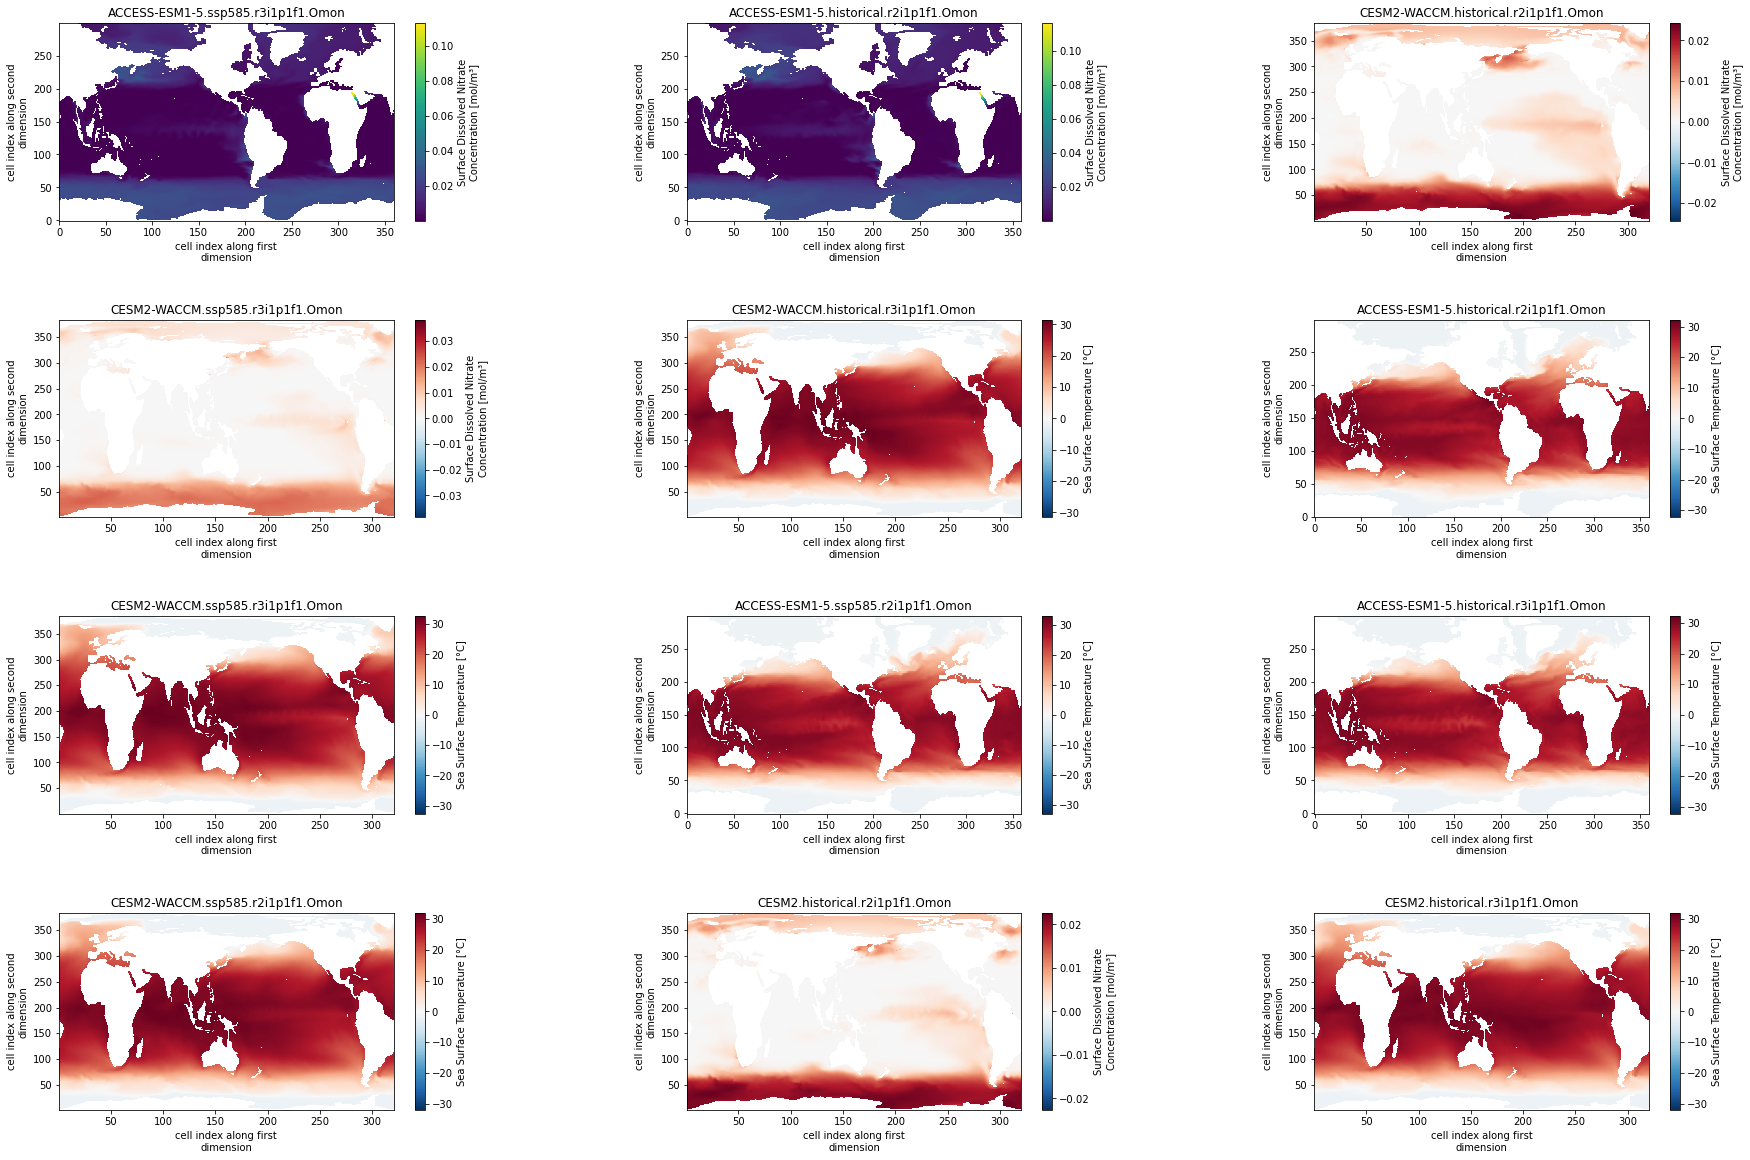

In [11]:
# quick example of how to loop over several models
from cmip6_preprocessing.utils import cmip6_dataset_id
fig, axarr = plt.subplots(ncols=3, nrows=4, figsize=[30,20])
for ax, (name, ds) in zip(axarr.flat, ddict.items()):
    # select the first time step
    ds = ds.isel(time=100)
    # select the datavariable
    da = ds[ds.variable_id]
    # plot
    
    da.plot(ax=ax)
    ax.set_title('.'.join(cmip6_dataset_id(ds).split('.')[2:6]))
    
fig.subplots_adjust(hspace=0.5, wspace=0.5)

## Postprocessing/ combining the data

In [12]:
from cmip6_preprocessing.postprocessing import merge_variables, concat_members, concat_experiments

In [15]:
ddict_combined_a = merge_variables(ddict)
ddict_combined_a.keys()

dict_keys(['ACCESS-ESM1-5.gn.ssp585.Omon.r3i1p1f1', 'ACCESS-ESM1-5.gn.historical.Omon.r2i1p1f1', 'CESM2-WACCM.gn.historical.Omon.r2i1p1f1', 'CESM2-WACCM.gn.ssp585.Omon.r3i1p1f1', 'CESM2-WACCM.gn.historical.Omon.r3i1p1f1', 'ACCESS-ESM1-5.gn.ssp585.Omon.r2i1p1f1', 'ACCESS-ESM1-5.gn.historical.Omon.r3i1p1f1', 'CESM2-WACCM.gn.ssp585.Omon.r2i1p1f1'])

In [16]:
def maybe_remove_attrs(ds, attr):
    if attr in ds.attrs.keys():
        del ds.attrs[attr]
    return ds
# remove the `variable_id` attr manually
ddict_combined_aa = {k:maybe_remove_attrs(ds, 'variable_id') for k,ds in ddict_combined_a.items()}
ddict_combined_b = concat_experiments(ddict_combined_aa)
ddict_combined_b.keys()

/srv/conda/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


dict_keys(['ACCESS-ESM1-5.gn.Omon.r3i1p1f1', 'ACCESS-ESM1-5.gn.Omon.r2i1p1f1', 'CESM2-WACCM.gn.Omon.r2i1p1f1', 'CESM2-WACCM.gn.Omon.r3i1p1f1'])

In [17]:
# # same thing for experiment_id
ddict_combined_bb = {k:maybe_remove_attrs(ds, 'experiment_id') for k,ds in ddict_combined_b.items()}
ddict_combined = concat_members(ddict_combined_bb)
ddict_combined.keys()

/srv/conda/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['experiment_id', 'variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(
/srv/conda/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: none.NCAR.CESM2-WACCM.none.r2i1p1f1.Omon.gn.none.none failed to combine with :'no3os' is not present in all datasets.
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")


dict_keys(['ACCESS-ESM1-5.gn.Omon'])